In [1]:
import os
import random
import metpy
import datetime
import s3fs
import numpy as np
import pandas as pd
import xarray as xr
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from pyresample import geometry, grid
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from skimage.filters import laplace
from skimage.filters import unsharp_mask
from skimage.transform import resize
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

fs = s3fs.S3FileSystem(anon = True)
model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")
random.seed(42)

2022-12-31 16:06:20.925422: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory
2022-12-31 16:06:20.925543: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory
2022-12-31 16:06:20.925555: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
/sharedData2/nshakoor/.conda/envs/fires/lib/python3.7/site-packages/pyresample/bilinear/__init__.py:49: UserWarning: XArray and/or zarr not found, XArrayBilinearResampler won't be available.
  warnings.warn("XArray and/or zarr not found, XArrayBilinearResampler won't be available.

In [9]:
def control(img):
    height, width = img.shape
    smallimg = resize(img, (round(height/2), round(width/2)))
    return resize(smallimg, (height, width))

def control_sharpening(img):
    """
    Returns a dictionary of errors for the given file without sharpening.
    
    Parameter path: The path to the given file
    Precondition: path is a string
    
    Parameter file: The file to evaluate the error of
    Precondition: file is a string
    """
    newimg = control(img)
    mae = mean_absolute_error(img, newimg)
    rmse = mean_squared_error(img, newimg, squared=False)
    return {'Control_MAE': mae, 'Control_RMSE': rmse}

def laplace_sharpening(img):
    """
    Returns a dictionary of errors for the given file using laplace sharpening.
    
    Parameter path: The path to the given file
    Precondition: path is a string
    
    Parameter file: The file to perform laplace sharpening on
    Precondition: file is a string
    """
    blurryimg = control(img)
    laplace_edges = laplace(blurryimg)
    sharpimg = blurryimg + laplace_edges
    mae = mean_absolute_error(img, sharpimg)
    rmse = mean_squared_error(img, sharpimg, squared=False)
    return {'LP_MAE': mae, 'LP_RMSE': rmse}

def unsharpmask_sharpening(img):
    """
    Returns a dictionary of errors for the given file using unsharpmask sharpening. To normalize images,
    each image is divided by its maximum value, and then multiplied by the same value after sharpening
    is completed.
    
    Parameter path: The path to the given file
    Precondition: path is a string
    
    Parameter file: The file to perform laplace sharpening on
    Precondition: file is a str
    """
    blurryimg = control(img)
    sharpimg = unsharp_mask(blurryimg/blurryimg.max(), radius=1, amount=1)*blurryimg.max()
    mae = mean_absolute_error(img, sharpimg)
    rmse = mean_squared_error(img, sharpimg, squared=False)
    return {'UM_MAE': mae, 'UM_RMSE': rmse}

def find_npy_file(path, file, band):
    """
    Returns the string name of another file from the same time for a given GOES band npy file,
    or None if there is no such file in the given directory.
    
    Parameter path: The path where the returned file is located in
    Precondition: path is a string to a directory relative to the current one, with .npy files
    
    Parameter file: A file from the same time the returned file should have
    Precondition: file is a string with the name of the original file, and includes the path
    
    Parameter band: GOES band the returned file should be from
    Precondition: band is a string of length 2
    """
    for x in os.listdir(path):
        if x[19:21] == band and file[23:37]==x[27:41]:
            return x

def update_dict(img, data):
    """
    Updates the dictionary with sharpening errors of a given file.
    
    Parameter path: The path to the given file
    Precondition: path is a string
    
    Parameter file: The file to perform laplace sharpening on
    Precondition: file is a string
    
    Parameter data: Dictionary containing sharpening errors
    Precondition: data is a dict
    """
    newdata = {}
    newdata.update(control_sharpening(img))
    newdata.update(laplace_sharpening(img))
    newdata.update(unsharpmask_sharpening(img))
    newdata.update(esrgan_sharpening(img))
    data.update(newdata)

In [20]:
maxi = 400
mini = 275

def load_image(array):
    """
    Returns loaded .npy file.
    
    Parameter path: Path to load .npy file from
    Precondition: path is a string
    """
#     new_array = 255*((array - mini) / (maxi - mini))
    new_array = array
    result = np.zeros((array.shape[0], array.shape[1], 3))
    result[:,:,0]= new_array
    result[:,:,1]= new_array
    result[:,:,2]= new_array
    return result

def preprocess_image(array):
    """
    Returns preprocessed input array.
    
    Parameter array: array to preprocess
    Precondition: array is a numpy array
    """
    height, width, depth = array.shape
    result = np.zeros((array.shape[0]//2, array.shape[1]//2, 3))
    hr_image = result[:,:,:]
    smallimg = resize(array, (round(height/2), round(width/2), 3))
    hr_image = smallimg
    
    hr_size = tf.convert_to_tensor(hr_image.shape[:-1])
    hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
    hr_image = tf.cast(hr_image, tf.float32)
    return tf.expand_dims(hr_image, 0)

def esrgan_sharpening(image):
    """
    Returns dictionary containing errors after using the ESRGAN model.
    
    Parameter path: path of image not including file name
    Precondition: path is a string
    
    Parameter file: file of the image
    Precondition: file is a string of a .npy file
    """
    hr_image = preprocess_image(load_image(image)) 
    fake_image = model(hr_image)
    fake_image = tf.squeeze(fake_image)
    fake_image = (np.mean(fake_image, axis=2)/255)*(maxi - mini) + mini

    fake_image = resize(np.array(fake_image), (image.shape[0], image.shape[1]))
    
    mae = mean_absolute_error(image, fake_image)
    rmse = mean_squared_error(image, fake_image, squared=False)
    return {'SR_MAE': mae, 'SR_RMSE': rmse}

In [10]:
image = random.choice(os.listdir(path))
image = np.load(path + image)

In [21]:
hr_image = preprocess_image(load_image(image)) 
fake_image = model(hr_image)
fake_image = tf.squeeze(fake_image)
# fake_image = (np.mean(fake_image, axis=2)/255)*(maxi - mini) + mini
fake_image = np.mean(fake_image, axis=2)

fake_image = resize(np.array(fake_image), (image.shape[0], image.shape[1]))

mae = mean_absolute_error(image, fake_image)
rmse = mean_squared_error(image, fake_image, squared=False)

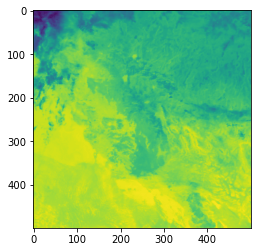

In [22]:
plt.imshow(image)

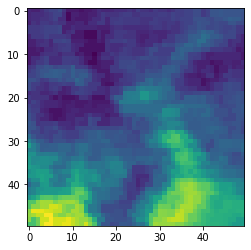

In [28]:
plt.imshow(image[0:50, 0:50])

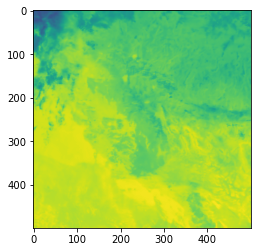

In [23]:
plt.imshow(fake_image)

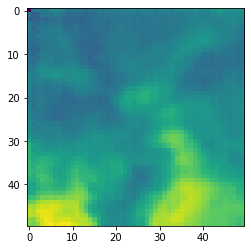

In [24]:
plt.imshow(fake_image[0:50, 0:50])

In [25]:
mae

0.8065771

In [ ]:
mae

In [26]:
rmse

0.95799816

In [ ]:
rmse

# Error

In [ ]:
mean = []
std = []
path = '../goes_files/npy_files/'
pathCM = '../goes_files/clear_sky_mask/'
files = os.listdir(pathCM)

for n in range(5):
    # data = []
    dataCM = []
    x = 0
    while x < 10:
        CM = random.choice(files)
        files.remove(CM)
        try:
            file07 = None
            file14 = None
            while file07 == None or file14 == None:
                file07 = find_npy_file(path, CM, '07')
                file14 = find_npy_file(path, CM, '14')

            img07 = np.load(path + file07)
            img14 = np.load(path + file14)

            mask = np.load(pathCM + CM)
            mask = mask.astype(bool)
            img07[mask]=0
            img14[mask]=0

            data07CM = {'File': file07, 'Band': file07[19:21]}
            update_dict(img07, data07CM)
            data14CM = {'File': file14, 'Band': file14[19:21]}
            update_dict(img14, data14CM)

            datadiffCM = {'Band': 'diff'}
            diffimgCM = img07 - img14
            update_dict(diffimgCM, datadiffCM)

            dataCM.append(data07CM)
            dataCM.append(data14CM)
            dataCM.append(datadiffCM)

            x += 1
        except:
            print(CM)
    dfCM = pd.DataFrame(dataCM)
    mean.append(dfCM.groupby(dfCM['Band']).agg({'Control_MAE': 'mean', 'Control_RMSE': 'mean',
                                'LP_MAE': 'mean', 'LP_RMSE': 'mean', 'UM_MAE': 'mean', 'UM_RMSE': 'mean', 'SR_MAE': 'mean', 'SR_RMSE': 'mean'}))
    std.append(dfCM.groupby(dfCM['Band']).agg({'Control_MAE': 'std', 'Control_RMSE': 'std',
                            'LP_MAE': 'std', 'LP_RMSE': 'std', 'UM_MAE': 'std', 'UM_RMSE': 'std', 'SR_MAE': 'std', 'SR_RMSE': 'std'}))

In [6]:
means = pd.DataFrame()
stds = pd.DataFrame()

for m in mean:
    means = pd.concat((m, means))
for s in std:
    stds = pd.concat((s, stds))

In [7]:
print('Average Mean Error')
means.groupby(means.index).agg({'Control_MAE': 'mean', 'Control_RMSE': 'mean',
                                'LP_MAE': 'mean', 'LP_RMSE': 'mean', 'UM_MAE': 'mean', 'UM_RMSE': 'mean', 'SR_MAE': 'mean', 'SR_RMSE': 'mean'})

Average Mean Error


,Control_MAE,Control_RMSE,LP_MAE,LP_RMSE,UM_MAE,UM_RMSE,SR_MAE,SR_RMSE
Band,,,,,,,,
07,16.995564,41.657909,14.684371,37.773319,14.853720,38.721832,27.897112,43.077698
14,16.837759,41.325184,14.550564,37.471237,14.715137,38.410801,27.799063,42.821716
diff,0.293138,0.596899,0.251474,0.536861,0.265860,0.563881,31.952570,32.164936


In [8]:
print("Standard Deviation of Means of Error")
stds.groupby(stds.index).agg({'Control_MAE': 'std', 'Control_RMSE': 'std',
                                'LP_MAE': 'std', 'LP_RMSE': 'std', 'UM_MAE': 'std', 'UM_RMSE': 'std', 'SR_MAE': 'std', 'SR_RMSE': 'std'})

Standard Deviation of Means of Error


,Control_MAE,Control_RMSE,LP_MAE,LP_RMSE,UM_MAE,UM_RMSE,SR_MAE,SR_RMSE
Band,,,,,,,,
07,1.761473,2.793995,1.514122,2.521624,1.558946,2.602584,1.162986,0.818350
14,1.749244,2.771834,1.505546,2.500267,1.550520,2.580402,1.164362,0.827500
diff,0.110230,0.136017,0.090825,0.118109,0.092892,0.117083,0.039856,0.035472


In [9]:
print("Average Standard Deviation of Error")
stds.groupby(stds.index).agg({'Control_MAE': 'mean', 'Control_RMSE': 'mean',
                                'LP_MAE': 'mean', 'LP_RMSE': 'mean', 'UM_MAE': 'mean', 'UM_RMSE': 'mean', 'SR_MAE': 'mean', 'SR_RMSE': 'mean'})

Average Standard Deviation of Error


,Control_MAE,Control_RMSE,LP_MAE,LP_RMSE,UM_MAE,UM_RMSE,SR_MAE,SR_RMSE
Band,,,,,,,,
07,6.075257,9.006995,5.253143,8.238051,5.386956,8.457125,5.428692,5.975353
14,6.013532,8.879961,5.201961,8.129744,5.333584,8.345526,5.427793,5.894588
diff,0.250634,0.431435,0.210950,0.385803,0.220730,0.395315,0.166045,0.157140
